In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from quantum_tools.contexts.quantum_caller import *
from quantum_tools.statistics import *
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.examples.prob_dists import *
from quantum_tools.rmt.unitary_param import *
from quantum_tools.rmt.utils import *
from quantum_tools.utilities import utils
from quantum_tools.statistics.probability import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.config import *
from quantum_tools.inflation import marginal_equality
from itertools import permutations
import numpy as np
from scipy import optimize
from quantum_tools.visualization.triangle_plot import *

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False

In [4]:
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))
triangle_permutation = utils.get_triangle_permutation(2)
symbolic_context = ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)

In [5]:
result_backlog = []

def minimize_callback(f):
    logged_results = []
    result_backlog.append(logged_results)
    def _callback(x):
        result = f(x)
#         print(result)
        print(result, end='\r')
        logged_results.append(result)
    return _callback

def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, norm_x * scale_std, x.shape)
    return x + delta_x

def plot_gd(h_f):
    plt.figure()
    plt.xlabel('Gradient Descent Step')
    plt.ylabel('Inequality Target')
    plt.title('Violations')
    plt.plot(np.arange(len(h_f)), h_f)
    # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, len(h_f), h_f.min(), h_f.max()])
    plt.grid(True)
    plt.show()
    
def plot_results(results):
    results = np.asarray(results)
    plt.figure()
    plt.xlabel('Step')
    plt.ylabel('Inequality Target')
    plt.title('Minimize Results')
    plt.plot(np.arange(len(results)), results)
    # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, len(results), results.min(), results.max()])
    plt.grid(True)
    plt.show()

In [6]:
def w_to_target(w):
    def _w_to_target(pd):
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        return np.sum(w * b)
    return _w_to_target

def w_to_target_sym(w):
    def _w_to_target(pd):
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        return np.sum(w * symmetrizingmatrix.dot(b))
    return _w_to_target

def pd_matching(pd_target):
    def _pd_matching(pd):
        return ProbDist.distance(pd, pd_target)
    return _pd_matching

In [8]:
fritz_param = np.loadtxt(utils.temp_dir('fritz_param.csv'))
mosekcert = np.loadtxt(utils.temp_dir('mosekcert.csv'))
gurobicert = np.loadtxt(utils.temp_dir('gurobicert.csv'))
transversal_hardy = np.loadtxt(utils.temp_dir('transversal_hardy.csv'))
transversal_symmetric_hardy = np.loadtxt(utils.temp_dir('transversal_symmetric_hardy.csv'))
mebs_non_accessible = np.loadtxt(utils.temp_dir('mebs_non_accessible.csv'))
gurobicertnosymmetry = np.loadtxt(utils.temp_dir('gurobicertnosymmetry.csv'))
mosekcertnosymmetry = np.loadtxt(utils.temp_dir('mosekcertnosymmetry.csv'))
binarycert = np.loadtxt(utils.temp_dir('binarycert.csv'))
GurobiCertFritzSym = np.loadtxt(utils.temp_dir('GurobiCertFritzSym.csv'))
MosekCertFritzSym = np.loadtxt(utils.temp_dir('MosekCertFritzSym.csv'))

symmetrizingmatrix = np.loadtxt(utils.temp_dir('symmetrizingmatrix.csv'), delimiter=',')

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/galaxy/unixhome/TFraser/quantum_tools/code/temp/GurobiCertFritzSym.csv'

In [9]:
w_to_target(transversal_hardy)(fritz(rvc))

-0.0025658369120796064

In [124]:
qc = QuantumCaller(None, rvc, triangle_permutation)
qc_ineq = QuantumCaller(w_to_target(transversal_hardy),rvc,triangle_permutation)
qc_match_rs = StateRestrictedQuantumCaller(pd_matching(qc.context(mebs_non_accessible)),rvc,triangle_permutation)
qc_match = QuantumCaller(pd_matching(target_pd),rvc, triangle_permutation)
qc_ineq_sym = QuantumCaller(w_to_target_sym(binarycert),rvc,triangle_permutation)
qc_ineq_rs = StateRestrictedQuantumCaller(w_to_target(transversal_hardy),rvc,triangle_permutation)
qc_ineq_sym_sym = SymmetricStateSymmetricMeasurementQuantumCaller(w_to_target_sym(gurobicert),rvc,triangle_permutation)
qc_ineq_lu = LocalUnitaryQuantumCaller(w_to_target_sym(gurobicert), rvc, triangle_permutation)
cc = ConvexityCaller(w_to_target(transversal_symmetric_hardy), rvc)

In [11]:
def exchange_parties(pd, how=None):
    support = pd._support
    if how is None: # Exchange parties in all ways
        summed_support = np.zeros(support.shape)
        for i in permutations(range(3)):
            summed_support += support.transpose(i)
        support = summed_support / np.sum(summed_support)
    else:
        support = support.transpose(how)
    return ProbDist(pd._rvc, support)

In [139]:
active_qc = qc_ineq_rs
# x0 = fritz_param[:active_qc.size]
# x0 = stochastic_jump(fritz_param, 0.01)#[:active_qc.size]
x0 = np.random.random(active_qc.size)*np.pi
# x0 = algebraic_support.ravel()
# x0 = np.hstack((np.random.normal(0,1,48), mebs_0_param, mebs_0_param, mebs_0_param))
# x0 = np.hstack((np.random.normal(0,1,4), fritz_param[4:active_qc.size]))
print(active_qc(x0))
res = optimize.minimize(active_qc, x0, tol=0.00001, method=None, callback=minimize_callback(active_qc))

0.0957696589158


In [117]:
qc_ineq(res['x'])

2.1572560967746943

In [118]:
convex_param(np.random.random(9)*np.pi/2)

array([ 0.7271 ,  0.00071,  0.00089,  0.19651,  0.06309,  0.00378,  0.00593,  0.00013,  0.00081,  0.00104])

<IPython.core.display.Javascript object>


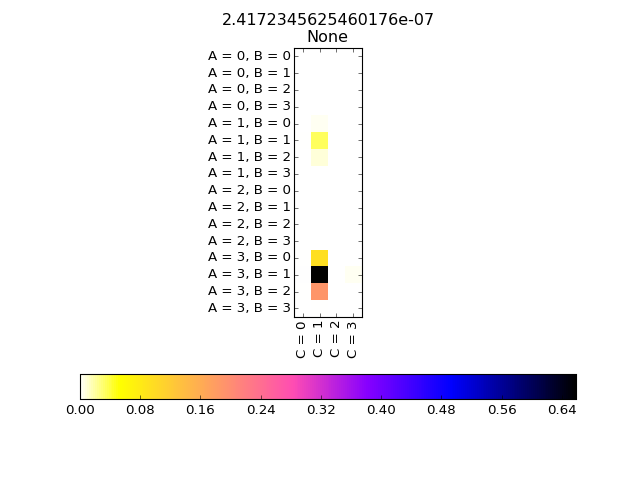

In [136]:
triangle_plot(active_qc.context(res['x']), title=active_qc(res['x']))

<IPython.core.display.Javascript object>


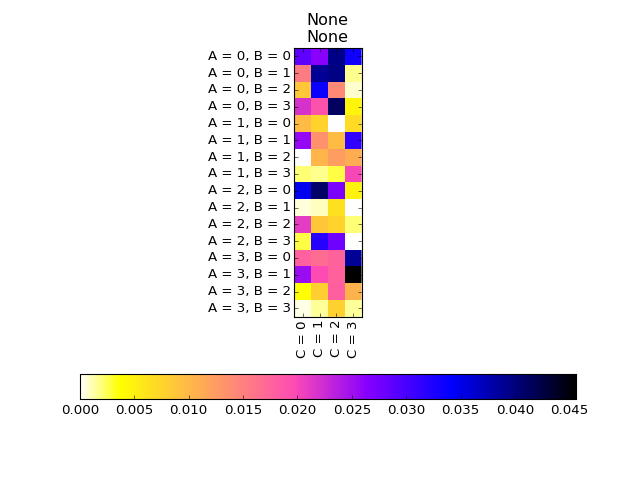

In [101]:
triangle_plot(cc.context(np.random.random(cc.size)))

In [ ]:
mebs_choice_results = {} # Clears it

In [25]:
for mebs_choice in combinations_with_replacement(range(4), 3):
    print(mebs_choice)
    continue_optimize = False
    if mebs_choice in mebs_choice_results:
        if mebs_choice_results[mebs_choice]['val'] < 0:
            pass
        else:
            continue_optimize = True
    else:
        continue_optimize = True
    if continue_optimize:
        active_qc = StateRestrictedQuantumCaller(w_to_target_sym(gurobicert),rvc,triangle_permutation, mebs_choice)
        x0 = np.random.normal(0,1,active_qc.size)
    #     print(active_qc(x0))
        mebs_res = optimize.minimize(active_qc, x0, tol=0.001, method=None, callback=minimize_callback(active_qc))
        mebs_choice_results[mebs_choice] = mebs_res
        mebs_choice_results[mebs_choice]['val'] = active_qc(mebs_res['x'])
    print(mebs_choice_results[mebs_choice]['val'])

(0, 0, 0)
-0.143002427156
(0, 0, 1)
-0.14300151059
(0, 0, 2)
-0.143002872891
(0, 0, 3)
-0.143002764819
(0, 1, 1)
-0.142996665789
(0, 1, 2)
-0.143002190616
(0, 1, 3)
-0.143002935642
(0, 2, 2)
-0.143001136891
(0, 2, 3)
-0.143002636296
(0, 3, 3)
-0.143000368588
(1, 1, 1)
-0.143002211394
(1, 1, 2)
-0.143002946782
(1, 1, 3)
-0.14300289879
(1, 2, 2)
-0.143002786385
(1, 2, 3)
-0.143002944258
(1, 3, 3)
-0.143001960052
(2, 2, 2)
-0.143002477175
(2, 2, 3)
-0.143002052268
(2, 3, 3)
-0.143001746962
(3, 3, 3)
-0.143002844139


In [112]:
target_pd = active_qc.context(res['x'])

In [103]:
temp=res['x']

In [56]:
br = r"\left|{}\right>"
mebs_strings = list(map(br.format, [r'\Phi^+', r'\Phi^-', r'\Psi^+', r'\Psi^-']))

results = []
for key, value in mebs_choice_results.items():
    configuration = ', '.join(mebs_strings[k] for k in key)
    results.append(r'{} \leftarrow {:.8} \\ '.format(configuration, value['val']))
Latex(*results)

In [87]:
target_state = cholesky(np.random.normal(0,1,16))
target_state /= (np.trace(target_state) + mach_eps)
state_param = StateParam(4)
def target_state_distance(param):
    return np.sqrt(np.sum(np.abs(state_param.gen(param) - target_state)**2))
res = optimize.minimize(target_state_distance, np.random.normal(0,1,15), tol=0.0001, callback=minimize_callback(target_state_distance))
print(target_state)
print(state_param.gen(res['x']))
print(np.trace(state_param.gen(res['x'])))
print(target_state_distance(res['x']))

[[ 0.18131+0.j       0.09180+0.05712j -0.07777-0.10968j -0.02389-0.06265j]
 [ 0.09180-0.05712j  0.18607-0.j       0.03254-0.10989j -0.00379-0.05783j]
 [-0.07777+0.10968j  0.03254+0.10989j  0.55823+0.j       0.19494+0.00291j]
 [-0.02389+0.06265j -0.00379+0.05783j  0.19494-0.00291j  0.07439+0.j     ]]
[[ 0.18131+0.j       0.09180+0.05712j -0.07777-0.10968j -0.02389-0.06265j]
 [ 0.09180-0.05712j  0.18607+0.j       0.03254-0.10989j -0.00379-0.05783j]
 [-0.07777+0.10968j  0.03254+0.10989j  0.55823+0.j       0.19494+0.00291j]
 [-0.02389+0.06265j -0.00379+0.05783j  0.19494-0.00291j  0.07439+0.j     ]]
(1+0j)
9.16151995075e-08


array([[ 0.03178+0.j     ,  0.00474-0.00678j,  0.00150+0.02335j, -0.00354-0.00949j],
       [ 0.00474+0.00678j,  0.04094+0.j     , -0.02856+0.08583j,  0.00124-0.03901j],
       [ 0.00150-0.02335j, -0.02856-0.08583j,  0.41142+0.j     ,  0.05322-0.01586j],
       [-0.00354+0.00949j,  0.00124+0.03901j,  0.05322+0.01586j,  0.51586+0.j     ]])

In [27]:
mebs_0_param = res['x']

In [31]:
mebs_3_param = res['x']

In [12]:
np.savetxt(utils.temp_dir('mebs_non_accessible.csv'), res['x'])

<IPython.core.display.Javascript object>


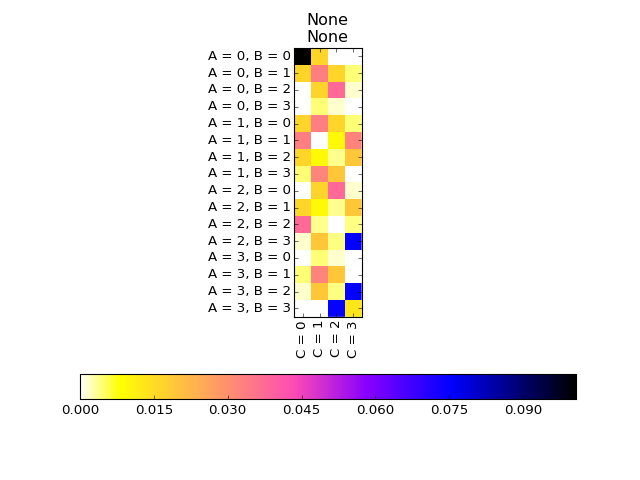

In [63]:
triangle_plot(exchange_parties(active_qc.context(res['x'])))

In [68]:
w_to_target_sym(gurobicert)(exchange_parties(active_qc.context(res['x'])))

0.29941855773178083

In [197]:
np.sum(symmetrizingmatrix[np.where(mosekcert != 0)], axis=1)

array([ 24.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  24.,  24.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  24.,  24.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  24.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  24.,  48.,  24.,  48.,  48.,  48.,  48.,
        48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  24.,  48.,  48.,  24.,  48.,  24.,  24.,
        48.,  48.,  48.,  48.,  48.,  24.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,  48.,
        48.,  48.,  24.,  24.,  48.,  48.,  48.,  48.,  48.,  24.,  24.,  48.,  48.,  24.,  48.,  24.])

In [109]:
algebraic_support = np.zeros((4,4,4))
algebraic_support[0, 0, 0] = 1
algebraic_support[2, 3, 3] = 1
algebraic_support[3, 2, 3] = 1
algebraic_support[3, 3, 2] = 1
algebraic_support /= np.sum(algebraic_support)
algebraic_pd = ProbDist(rvc, algebraic_support)